In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lminfo = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
lminfo=list(np.ravel(lminfo))[0]
print(lminfo)

2017-08-23


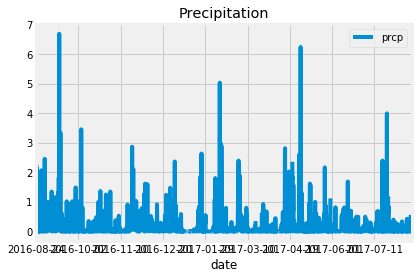

In [29]:
# Calculate the date 1 year ago from the last data point in the database
yearago=dt.date(2017, 8, 23)- dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prec= session.query(Measurement.date, Measurement.prcp)\
                   .filter(Measurement.date>yearago)\
                    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precTable=pd.DataFrame(prec)
precTable=precTable.set_index('date')

# Sort the dataframe by date
precTable=precTable.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precTable.plot(title="Precipitation")

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precTable.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stations=session.query(Station).count()
print(f"There are {stations} stations")

There are 9 stations


In [14]:
# What are the most active stations? (i.e. what stations have the 
#most rows)?
# List the stations and the counts in descending order.
activestations=session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculateof the most active station:
ID=activestations[0][0]

#most active station
SName=session.query(Station.name).filter_by(station = ID)
SName=SName[0][0]
print (f"{SName} is the most active station")

#the lowest temperature recorded, 
lowT=session.query(Measurement.tobs).filter(Measurement.station == ID)\
.order_by(Measurement.tobs.asc()).first()
lowT=lowT[0]
print (f"The lowest temperature is {lowT}")

#highest temperature recorded,
highT=session.query(Measurement.tobs).filter(Measurement.station == ID)\
.order_by(Measurement.tobs.desc()).first()
highT=highT[0]
print (f"The highest temperature is {highT}")

#average temperature 
avT=session.query(func.avg(Measurement.tobs))\
.filter(Measurement.station == ID)
avT=avT[0][0]
print (f"The average temperature is {avT}")

WAIHEE 837.5, HI US is the most active station
The lowest temperature is 54.0
The highest temperature is 85.0
The average temperature is 71.66378066378067


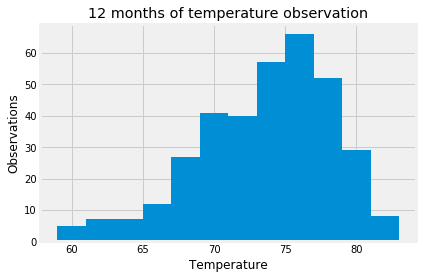

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
HObs = session.query(Measurement.date, Measurement.tobs)\
    .filter (Measurement.date>yearago)\
    .filter (Measurement.station == ID)\
    .order_by (Measurement.date)\
    .all()

HObsDF=pd.DataFrame(HObs)
plt.hist(HObsDF['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Observations")
plt.title("12 months of temperature observation")
plt.show()

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d      
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate 
#the tmin, tavg, and tmax for your trip using the 
#previous year's data for those same dates.
# function usage example
TripR=calc_temps('2011-02-28', '2011-03-05')
TripR

[(61.0, 69.75510204081633, 75.0)]

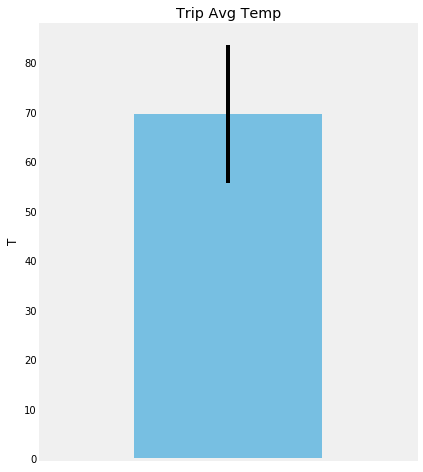

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
TripDF=pd.DataFrame(TripR, columns=['Min', 'Avg', 'Max'])
AvgT=TripDF['Avg']
MMT=TripDF.iloc[0]['Max'] - TripDF.iloc[0]['Min']
AvgT.plot(kind='bar', yerr=MMT, figsize=(6,8), alpha=0.5)
plt.title("Trip Avg Temp")
plt.ylabel("T")
plt.xticks([])
plt.grid()
plt.show()

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
TotalRain = session.query(Station.station, func.sum(Measurement.prcp),\
      Station.name, Station.elevation, Station.latitude,\
      Station.longitude).filter(Measurement.station == Station.station)\
        .filter(Measurement.date >= '2011-02-28')\
        .filter(Measurement.date <= '2011-03-05')\
        .group_by(Station.station).order_by(func.sum(Measurement.prcp).desc())

for row in TotalRain:
    print (f"Station:  {row[0]}, Rainfall:  {row[1]}, Location:  {row[2]}, Elevation:  {row[3]}, Latitude:  {row[4]}, Longitude:  {row[5]}")
    print()     

Station:  USC00518838, Rainfall:  2.33, Location:  UPPER WAHIAWA 874.3, HI US, Elevation:  306.6, Latitude:  21.4992, Longitude:  -158.0111

Station:  USC00519281, Rainfall:  2.23, Location:  WAIHEE 837.5, HI US, Elevation:  32.9, Latitude:  21.45167, Longitude:  -157.84888999999998

Station:  USC00519523, Rainfall:  2.19, Location:  WAIMANALO EXPERIMENTAL FARM, HI US, Elevation:  19.5, Latitude:  21.33556, Longitude:  -157.71139

Station:  USC00514830, Rainfall:  1.96, Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US, Elevation:  7.0, Latitude:  21.5213, Longitude:  -157.8374

Station:  USC00516128, Rainfall:  1.45, Location:  MANOA LYON ARBO 785.2, HI US, Elevation:  152.4, Latitude:  21.3331, Longitude:  -157.8025

Station:  USC00513117, Rainfall:  1.44, Location:  KANEOHE 838.1, HI US, Elevation:  14.6, Latitude:  21.4234, Longitude:  -157.8015

Station:  USC00519397, Rainfall:  1.38, Location:  WAIKIKI 717.2, HI US, Elevation:  3.0, Latitude:  21.2716, Longitude:  -157.8168

Stat

## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
